In [53]:
# import os
# import cv2
# os.getcwd()
# # import cv2 as cv
# image=cv2.imread("coin.jpg",0)
# image=cv2.resize(image,(1728,1270))
# edges=cv2.Canny(image,50,150)
# # # img=cv.imwrite("./results/20_200.png",edges)
# cv2.imshow('edge',edges)
# cv2.waitKey(0)
# cv2.destroyAllWindows

### 显示函数

In [54]:
import matplotlib.pyplot as plt
def show(num,image_list,name_list=['1','2','3','4','5']):
    if num==1:
        plt.imshow(image_list,cmap='gray')
        plt.axis('off')
    else :
        plt.figure(figsize=(14, 7))
        for i in range(num) :
            plt.subplot(1,num,i+1)
            plt.imshow(image_list[i],cmap='gray')
            plt.title(name_list[i])
            plt.axis('off')
        

### 高斯滤波的实现

(2127, 3543, 3)


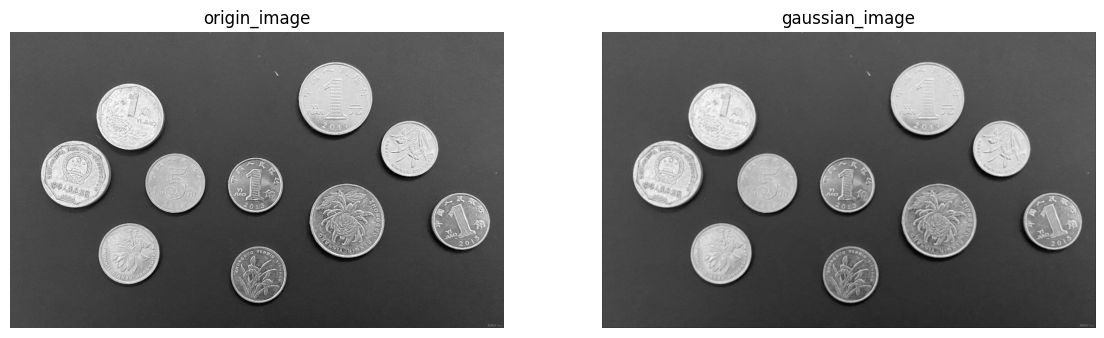

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
def gauss_kernel(size=3,sigma=1):      #k=6*a+1
    p=size//2
    kernel=np.zeros((size,size))
    for x in range(-p,p+1) :
        for y in range(-p,p+1) :
            kernel[x+p,y+p]=(1/2*np.pi*sigma**2)*np.exp(-(x**2+y**2)/(2*sigma**2))
    kernel/=kernel.sum()
    return kernel
def linear_filter(image,kernel):
    # height, width, channels = image.shape
    height, width = image.shape
    kernel_size=kernel.shape[0]
    pad=kernel_size//2
    padded_image = np.pad(image, pad, mode='constant')
    new_image = np.zeros_like(image)
    # for channel in range(channels):
    for row in range(height):
        for col in range(width):            
            # new_image[row, col, channel] = np.sum(np.multiply(kernel ,padded_image[row:row + kernel_size, col:col + kernel_size, channel]))
            new_image[row, col] = np.sum(np.multiply(kernel ,padded_image[row:row + kernel_size, col:col + kernel_size]))
    new_image = np.clip(new_image, 0, 255)
    return new_image
# origin_image=plt.imread('girl.jpg')
# origin_image=(origin_image*255).astype(np.uint8)
origin_image=plt.imread('coin2.jpg')
print(origin_image.shape)
origin_image=cv2.resize(origin_image,(origin_image.shape[1]//3,origin_image.shape[0]//3))  #长宽
# origin_image=plt.imread('coin1.jpg')
# print(h,w)
# origin_image=cv2.resize(origin_image,(int(w/3),int(h/3)))
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_RGB2GRAY)
# print(origin_image.dtype)
kernel=gauss_kernel()
# print(kernel)
gaussian_image=linear_filter(origin_image,kernel)
# print(gaussian_image.dtype) 
show(2,[origin_image,gaussian_image],['origin_image','gaussian_image'])
# show(1,gaussian_image)

### 计算图像的梯度图并获得梯度方向

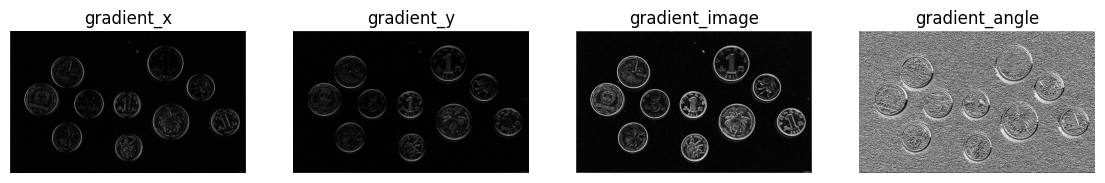

In [56]:
def Get_gradient_img(new_image):
    x_kernel = np.array([[-1, 1]])
    y_kernel = np.array([[-1], [1]])
    y,x=new_image.shape[0:2]
    #因为new_image是np.uint8，为了保存梯度的方向需要保存负号
    new_image_x=np.zeros_like(new_image,dtype=np.float64)
    new_image_y=np.zeros_like(new_image,dtype=np.float64)  
    for i in range(x) :
        for j in range(y) :
            if i==x-1 : 
                new_image_x[j][i]=0
            else : 
                new_image_x[j][i]=np.dot(x_kernel,np.array([[new_image[j][i]],[new_image[j][i+1]]]))[0][0]
            if j==y-1 : 
                new_image_y[j][i]=0
            else : 
                new_image_y[j][i]=np.dot(np.array([[new_image[j][i],new_image[j+1][i]]]),y_kernel)[0][0]
    return new_image_x,new_image_y
# show(4,[gradient_x,gradient_y,gradient_image,gradient_angle],['gradient_x','gradient_y','gradient_image','gradient_angle'])
def Get_gradient_img_sobel(new_image):
    sobel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    sobel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    y,x=new_image.shape[0:2]
    padded_image = np.pad(new_image, 1, mode='constant')
    new_image_x=np.zeros_like(new_image,dtype=np.float64)
    new_image_y=np.zeros_like(new_image,dtype=np.float64)
    for i in range(y):
        for j in range(x):
        # 提取当前像素区域
            # 计算卷积结果
            new_image_x[i, j] = np.sum(padded_image[i:i+3, j:j+3] * sobel_x)
            new_image_y[i, j] = np.sum(padded_image[i:i+3, j:j+3] * sobel_y)
    return new_image_x,new_image_y
gradient_x,gradient_y=Get_gradient_img_sobel(gaussian_image)
gradient_image= np.clip(np.sqrt(gradient_x**2 + gradient_y**2),0,255).astype(np.uint8)
gradient_angle=np.arctan2(gradient_y,gradient_x) #弧度制
gradient_x=np.abs(gradient_x)
gradient_y=np.abs(gradient_y)
# show(1,gradient_image)
show(4,[gradient_x,gradient_y,gradient_image,gradient_angle],['gradient_x','gradient_y','gradient_image','gradient_angle'])

### 对梯度图进行非极大化抑制

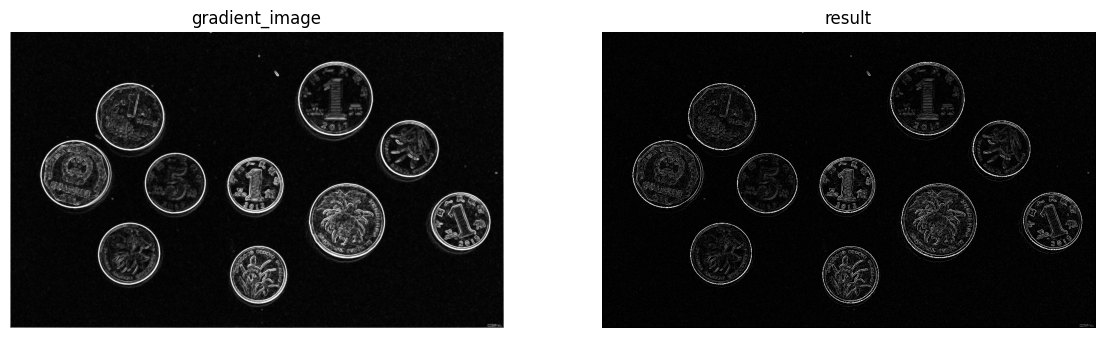

In [57]:
def Non_maximum_suppression (gradient_img,tan):
    result=np.zeros_like(gradient_img)
    # result=gradient_img.copy()
    y,x=result.shape
    for i in range(1,x-1) :
        for j in range(1,y-1) :
            # if gradient_img[j][i] < 4:
            #     result[j][i]=0
            #     continue
            #注意正方向指向右下角
            if np.abs(tan[j][i]) >1:
                gradient_2=gradient_img[j-1][i]
                gradient_4=gradient_img[j+1][i]
                #g1 g2
                #   C
                #   g4 g3 
                if tan[j][i] >0:
                    gradient_1=gradient_img[j-1][i-1]
                    gradient_3=gradient_img[j+1][i+1]
                #   g2 g1
                #   C
                #g3 g4  
                else :
                    gradient_1=gradient_img[j-1][i+1]
                    gradient_3=gradient_img[j+1][i-1]
                Temp1 = np.abs(1/tan[j][i]) * gradient_1 + (1 - 1/np.abs(tan[j][i])) * gradient_2
                Temp2 = np.abs(1/tan[j][i]) * gradient_3 + (1 - 1/np.abs(tan[j][i])) * gradient_4
            else :
                gradient_2=gradient_img[j][i-1]
                gradient_4=gradient_img[j][i+1]
                #g1
                #g2 C g4
                #     g3
                if tan[j][i] >0:
                    gradient_1=gradient_img[j-1][i-1]
                    gradient_3=gradient_img[j+1][i+1]
                #     g3
                #g2 C g4
                #g1
                else :
                    gradient_1=gradient_img[j+1][i-1]
                    gradient_3=gradient_img[j-1][i+1]
            # 线性插值
                Temp1 = np.abs(tan[j][i]) * gradient_1 + (1 - np.abs(tan[j][i])) * gradient_2
                Temp2 = np.abs(tan[j][i]) * gradient_3 + (1 - np.abs(tan[j][i])) * gradient_4
            if  gradient_img[j][i] >= Temp1 and  gradient_img[j][i] >= Temp2:
                result[j][i] =  gradient_img[j][i]       
    return result
tan=np.tan(gradient_angle)
cot=np
result=Non_maximum_suppression(gradient_image,tan)
show(2,[gradient_image,result],['gradient_image','result'])
# show(1,result)


### 双阈值法

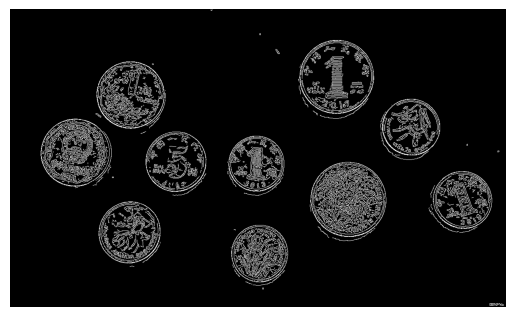

In [63]:
def count_result(img):
    arr=img
    # 创建一个空字典用于存储统计结果
    count_dict = {}
    # 遍历数组，统计每个数字的个数
    for row in arr:
        for num in row:
            if num in count_dict:
                count_dict[num] += 1
            else:
                count_dict[num] = 1
    # 对统计结果按照值（出现次数）进行排序
    sorted_count = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    # 将排序后的统计结果写入到 txt 文件中
    with open(f'count_result_.txt', 'w') as file:
        # 逐行写入排序后的键值对
        for key, value in sorted_count:
            file.write(f"数字 {key} 出现了 {value} 次\n")
def Hysteresis_thresholding(edge_non_max_sup,high_threshold,low_threshold):
    y,x=edge_non_max_sup.shape
    final_img=edge_non_max_sup.copy()
    final_img[final_img>=high_threshold]=255
    final_img[final_img<=low_threshold]=0
    for i in range(1,x-1):
        for j in range(1,y-1):
            if final_img[j][i]<high_threshold and final_img[j][i]>low_threshold :
                final_img[j][i]=0
                list_=[final_img[j-1][i-1],final_img[j-1][i],final_img[j-1][i+1],final_img[j][i-1],
                    final_img[j][i+1],final_img[j+1][i-1],final_img[j+1][i],final_img[j+1][i+1]]
                for value in list_ :
                    if value >=high_threshold :
                        final_img[j][i]=255
                        break
                   
    return final_img
#低阈值是为了去掉弱边缘，高阈值保留了强边缘，通过
q=Hysteresis_thresholding(result,45,25)   
                                         

show(1,q)
cv2.imshow('Detected Coins', q)  # 显示图像`
cv2.waitKey(0)  # 等待用户按下任意键后关闭图像窗口
cv2.destroyAllWindows()  # 关闭所有打开的图像窗口


In [9]:
import numpy as np
class Canny:
    def __init__(self, Guassian_kernel_size, sigma, image, high_threshold, low_threshold):
        '''
        :param Guassian_kernel_size: 高斯滤波器尺寸
        :param img: 输入的图片
        :param HT_high_threshold: 滞后阈值法中的高阈值
        :param HT_low_threshold: 滞后阈值法中的低阈值
        '''
        self.Guassian_kernel_size = Guassian_kernel_size
        self.sigma=sigma
        self.image = image
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold
        self.y,self.x=self.image.shape
        self.angle=np.zeros((self.y,self.x))
        #计算梯度的卷积核
        self.x_kernel=[[-1,1]]
        self.y_kernel=[[-1],[1]]
        self.canny_algorithm()
    
    def Gaussian_kernel(self):
        p=self.Guassian_kernel_size//2
        kernel=np.zeros((self.Guassian_kernel_size,self.Guassian_kernel_size))
        for x in range(-p,p+1) :
            for y in range(-p,p+1) :
                kernel[x+p,y+p]=1/(2*np.pi*self.sigma**2)*np.exp(-(x**2+y**2)/(2*self.sigma**2))
        kernel/=kernel.sum()
        return kernel
    
    def GaussianBlur(self):

        print ('Get_gaussianblur_img')
        #如果数据类型是float，说明像素值范围是0-1
        t=str(self.image.dtype)
        if 'float' in t :
            self.image=(self.image*255).astype(np.uint8)
        gaussian_kernel=self.Gaussian_kernel()
        height, width = self.image.shape
        gaussian_kernel_size=gaussian_kernel.shape[0]
        pad=gaussian_kernel_size//2
        padded_image = np.pad(self.image, pad_width=(pad,pad), mode='constant')
        self.image = np.zeros_like(self.image)
        for row in range(height):
            for col in range(width):            
                self.image[row, col] = np.sum(np.multiply(gaussian_kernel ,padded_image[row:row + gaussian_kernel_size, col:col + gaussian_kernel_size]))
        self.image = np.clip(self.image, 0, 255)
        self.gaussian_image=self.image
        return self.image
        
    def Get_gradient_img(self):
        '''
        计算梯度图和梯度方向矩阵。
        :return: 生成的梯度图
        '''
        print ('Get_gradient_img')
        x_kernel = np.array([[-1, 1]])
        y_kernel = np.array([[-1], [1]])
        #因为self.image是np.uint8，为了保存梯度的方向需要保存负号
        self.gradient_x=np.zeros_like(self.image,dtype=np.float64)
        self.gradient_y=np.zeros_like(self.image,dtype=np.float64)  
        for i in range(self.x) :
            for j in range(self.y) :
                if i==self.x-1 : 
                    self.gradient_x[j][i]=0
                else : 
                    self.gradient_x[j][i]=np.dot(x_kernel,np.array([[self.image[j][i]],[self.image[j][i+1]]]))[0][0]
                if j==self.y-1 : 
                    self.gradient_y[j][i]=0
                else : 
                    self.gradient_y[j][i]=np.dot(np.array([[self.image[j][i],self.image[j+1][i]]]),y_kernel)[0][0]
        self.image= np.clip(np.sqrt(self.gradient_x**2 + self.gradient_y**2),0,255).astype(np.uint8)
        self.gradient_image=self.image
        self.angle=np.tan(np.arctan2(self.gradient_y,self.gradient_x))
        return self.image

    def Non_maximum_suppression (self):
        '''
        对生成的梯度图进行非极大化抑制，将tan值的大小与正负结合，确定离散中梯度的方向。
        :return: 生成的非极大化抑制结果图
        '''
        print ('Non_maximum_suppression')
        result=np.zeros_like(self.image)
        y,x=result.shape
        for i in range(1,x-1) :
            for j in range(1,y-1) :
                if self.image[j][i] < 4:
                    result[j][i]=0
                    continue
                #注意正方向指向右下角
                if np.abs(self.angle[j][i]) >1:
                    gradient_2=self.image[j-1][i]
                    gradient_4=self.image[j+1][i]
                    #g1 g2
                    #   C
                    #   g4 g3 
                    if self.angle[j][i] >0:
                        gradient_1=self.image[j-1][i-1]
                        gradient_3=self.image[j+1][i+1]
                    #   g2 g1
                    #   C
                    #g3 g4  
                    else :
                        gradient_1=self.image[j-1][i+1]
                        gradient_3=self.image[j+1][i-1]
                else :
                    gradient_2=self.image[j][i-1]
                    gradient_4=self.image[j][i+1]
                    #g1
                    #g2 C g4
                    #     g3
                    if self.angle[j][i] >0:
                        gradient_1=self.image[j-1][i-1]
                        gradient_3=self.image[j+1][i+1]
                    #     g3
                    #g2 C g4
                    #g1
                    else :
                        gradient_1=self.image[j+1][i-1]
                        gradient_3=self.image[j-1][i+1]
                # 线性插值
                Temp1 = np.abs(self.angle[j][i]) * gradient_1 + (1 - np.abs(self.angle[j][i])) * gradient_2
                Temp2 = np.abs(self.angle[j][i]) * gradient_3 + (1 - np.abs(self.angle[j][i])) * gradient_4
                if  self.image[j][i] >= Temp1 and  self.image[j][i] >= Temp2:
                    result[j][i] =  self.image[j][i]
                else:
                    result[j][i] = 0   
        self.image=result      
        self.edge_non_max_sup=result 
        return self.image

    def Hysteresis_thresholding(self):
        '''
        对生成的非极大化抑制结果图进行滞后阈值法，用强边延伸弱边，这里的延伸方向为梯度的垂直方向，
        将比低阈值大比高阈值小的点置为高阈值大小，方向在离散点上的确定与非极大化抑制相似。
        :return: 滞后阈值法结果图
        '''
        print ('Hysteresis_thresholding')
        final_img=self.image.copy()
        final_img[final_img>=self.high_threshold]=255
        final_img[final_img<=self.low_threshold]=0
        for i in range(1,self.x-1):
            for j in range(1,self.y-1):
                if final_img[j][i]<self.high_threshold & final_img[j][i]>self.low_threshold :
                    list_=[final_img[j-1][i-1],final_img[j-1][i],final_img[j-1][i+1],final_img[j][i-1],
                        final_img[j][i+1],final_img[j+1][i-1],final_img[j+1][i],final_img[j+1][i+1]]
                    for value in list_ :
                        if value >=self.high_threshold :
                            final_img[j][i]=255
                            break
                        else :
                            final_img[j][i]=0 
        self.image=final_img
        self.final_image=final_img
        return self.image

    def canny_algorithm(self):
        '''
        按照顺序和步骤调用以上所有成员函数。
        :return: Canny 算法的结果
        '''  
        self.GaussianBlur()
        self.Get_gradient_img()
        self.Non_maximum_suppression()
        self.Hysteresis_thresholding()
# origin_image=plt.imread('coin.jpg')
# origin_image=cv2.resize(origin_image,(1728,1270))
# origin_image = cv2.cvtColor(origin_image, cv2.COLOR_RGB2GRAY)
# canny=Canny(7,1,origin_image,12,4)
# show(1,canny.image)


In [10]:
import numpy as np
import math
class Hough_transform:
    def __init__(self, image, angle, step=4, threshold=40):  #40
        '''
        :param image: 输入的图像
        :param angle: 输入的梯度方向矩阵
        :param step: Hough 变换步长大小
        :param threshold: 筛选单元的阈值
        '''
        self.image = image
        self.angle = np.abs(angle)
        self.y, self.x = self.image.shape #y代表行，x代表列
        self.radius = math.ceil(math.sqrt(self.y**2 + self.x**2)) #最大半径 
        self.step = step 
        self.vote_matrix = np.zeros([math.ceil(self.y / self.step), math.ceil(self.x / self.step), math.ceil(self.radius / self.step)])
        self.threshold = threshold
        self.circles = []

    def Hough_transform_algorithm(self):
        '''
        按照 x,y,radius 建立三维空间，根据图片中边上的点沿梯度方向对空间中的所有单
        元进行投票。每个点投出来结果为一折线。
        :return:  投票矩阵
        '''
        print ('Hough_transform_algorithm')
        for i in range(1,self.y-1) :
            for j in range(1,self.x-1) :
                if self.image[i][j]>0:
                    #沿梯度的正方向
                    x_=j
                    y_=i
                    r=0
                    while x_<self.x and y_<self.y   : 
                        self.vote_matrix[math.floor(y_ / self.step),math.floor(x_ / self.step), math.floor(r/self.step)]+=1                
                        y_ += np.abs(self.step * math.sin(self.angle[i][j]))
                        x_ += np.abs(self.step * math.cos(self.angle[i][j]))
                        r += self.step
                    # 清零反向投票 
                    x_=j
                    y_=i
                    r=0
                    #沿梯度负方向
                    while x_>0 and y_>0 :
                        self.vote_matrix[math.floor(y_ / self.step),math.floor(x_ / self.step), math.floor(r/self.step)] +=1                
                        y_ -= np.abs(self.step * math.sin(self.angle[i][j]))
                        x_ -= np.abs(self.step * math.cos(self.angle[i][j]))
                        r += self.step
        print('投票完成')
        return self.vote_matrix
    def Select_Circle(self):
        '''
        按照阈值从投票矩阵中筛选出合适的圆，并作极大化抑制，这里的非极大化抑制我采
        用的是邻近点结果取平均值的方法，而非单纯的取极大值。
        :return: None
        '''
        print ('Select_Circle')
        #选出大于阈值的
        candidate=[]
        for i in range(0,math.ceil(self.y/self.step)) :
            for j in range(0,math.ceil(self.x/self.step)):
                for r in range(0,math.ceil(self.radius/self.step)):
                    if self.vote_matrix[i][j][r]>=self.threshold :
#                         在霍夫变换中，通常是将图像分割成一个个的格子，每个格子对应参数空间中的一个点或者区域。当需要将格子映射回图像空间时，取格子的中心点作为映射点是比较常见的选择，这样能够更好地保持空间的对称性。
# 假设步长（self.step）表示格子的边长，那么格子的中心点位于格子的中心，即格子的左上角坐标加上步长的一半。这样做的好处是确保了映射回图像空间的坐标落在格子的中心点，而不是在格子的边缘上。
# 在代码中，加上步长的一半是为了得到格子的中心坐标。这样计算出来的坐标更准确，能够更好地表示相应格子在图像空间中的位置。
                        a=math.ceil(j*self.step+1/2*self.step)
                        b=math.ceil(i*self.step+1/2*self.step)
                        r=math.ceil(r*self.step+1/2*self.step)
                        candidate.append([a,b,r])
                        # candidate.append((a,b,r))
        self.candidate=candidate
        over=[]#已经判断完毕的
        result=[]
        for circle in candidate :
            compare=candidate#一样的列表用于循环比较
            avg=[0,0,0]
            count=0
            for near in compare :
                if near in over :
                    continue
                dis =math.sqrt((circle[0]-near[0])**2+(circle[1]-near[1])**2)
                if dis <circle[2]+near[2] :
                    avg[0]+=near[0]
                    avg[1]+=near[1]
                    avg[2]+=near[2]
                    count+=1
                    over.append(near)
            if count==0 :
                continue
            result.append([t/count for t in avg ])
        self.circles=result
        # for circle_result in self.circles:
        #     print("Circle core: (%f, %f)  Radius: %f" % (circle_result[0], circle_result[1], circle_result[2]))
    def Calculate(self):
        '''
        按照算法顺序调用以上成员函数
        :return: 圆形拟合结果图，圆的坐标及半径集合
        '''
        self.Hough_transform_algorithm()
        self.Select_Circle()
        # self.circles = self.non_maximum_suppression(self.candidate)
        return self.circles
hough=Hough_transform(q,gradient_angle)
hough.Calculate()

Hough_transform_algorithm
投票完成
Select_Circle


[[776.8915662650602, 160.16867469879517, 88.4578313253012],
 [954.0, 266.0, 82.0],
 [952.0, 272.0, 78.0],
 [285.40983606557376, 202.2622950819672, 78.06557377049181],
 [192.1818181818182, 327.09090909090907, 101.63636363636364],
 [158.0, 340.0, 96.0],
 [159.0, 345.0, 95.0],
 [388.0, 346.0, 90.0],
 [386.0, 353.0, 86.0],
 [382.0, 362.0, 86.0],
 [389.0, 357.0, 82.0],
 [159.0, 342.0, 89.0],
 [956.5142857142857, 281.77142857142854, 65.42857142857143],
 [154.30769230769232, 341.79487179487177, 75.23076923076923],
 [392.51428571428573, 367.6, 70.0],
 [270.0, 506.0, 102.0],
 [268.0, 512.0, 98.0],
 [586.5555555555555, 370.05555555555554, 65.0],
 [262.0, 522.0, 98.0],
 [270.0, 518.0, 94.0],
 [582.0, 550.0, 102.0],
 [692.0, 490.0, 108.0],
 [655.3333333333334, 516.6666666666666, 99.33333333333333],
 [806.2790697674419, 452.4186046511628, 85.44186046511628],
 [1078.4166666666667, 453.1666666666667, 67.33333333333333],
 [284.7142857142857, 531.1428571428571, 73.28571428571429],
 [595.8867924528302, 

In [11]:
avg=[1,2,3]
x=[y/2 for y in avg]
print(x)

[0.5, 1.0, 1.5]


In [12]:
z=hough.vote_matrix
z=z.flatten() 
sorted_indices = np.argsort(z)[::-1]  # 从大到小排序后的索引
# 获取前10个最大值
top_10_max_values = z[sorted_indices[:15]]
print("最大的前15个数:", top_10_max_values)

最大的前15个数: [219. 212. 210. 181. 174. 167. 167. 161. 160. 149. 144. 144. 138. 134.
 134.]


In [13]:
img=plt.imread('coin.jpg')
img=cv2.resize(img,(int(img.shape[1])//3,int(img.shape[0])//3))
# for circle in hough.circles:
#         cv2.circle(img, (math.ceil(circle[0]), math.ceil(circle[1])), math.ceil(circle[2]), (132, 135, 239), 4)
#         print('Finished!')
for (x, y, r) in hough.circles:
        print(f'圆心坐标: ({x}, {y}), 半径: {r}')
        x = int(x)
        y = int(y)
        r = int(r)
        cv2.circle(img, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(img, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'coin.jpg'